## 1. Постановка задачи

Для приложения ленты новостей команда ML создала два новых алгоритма рекомендаций. 

Бизнес-гипотеза: "Новые рекомендации показывают посты, более интересные пользователям". Ожидается, что новые алгоритмы сделают пользователей счастливее, т.е. удлиниться LTV, повысятся денежные конверсии и т.п.

Предложенные алгоритмы:

1. Показ пользователям постов, наиболее похожих на те, которые он лайкал.
2. Показ пользователям постов, которые лайкали похожие на него пользователи.

Пользователи в базе разбиты на четыре группы (0-3). 

В период с '2024-03-29' по '2024-04-04' параллельно проводятся два теста:

Первый эксперимент:

* exp_group = 0 – Контрольная группа
* exp_group = 3 - Рекомендации "постов, которые лайкали похожие на пользователя люди"

Второй эксперимент:

* exp_group = 1 - Контрольная группа
* exp_group = 2 - Рекомендации "похожих на лайкнутые постов"

Задача:

1. При помощи A/B-тестирования проанализировать результаты двух экспериментов и дать рекомендации по 
применению новых алгоритмов на всех пользователях.

2. Рассмотреть разнообразие статистических тестов для метрик отношения.

In [1]:
import os
from dotenv import load_dotenv

from datetime import date
import numpy as np
import pandas as pd
import pandahouse as ph
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import pingouin as pg

from warnings import filterwarnings
filterwarnings("ignore")

sns.set(rc={'figure.figsize':(10,6)})
sns.set_palette('Set2')


In [2]:
# Подключение к базе
load_dotenv()

connection = {
    'host': os.getenv('HOST'),
    'password': os.getenv('PASSWORD'),
    'user': os.getenv('DB_USER')
}

## 2. Выбор метрики для сравнения

В качестве метрики, увеличение которой могло бы нам сказать, что посты для пользователей стали интереснее могли бы быть, например:
- время, проведенное в ленте;
- количество просмотренный постов на единицу времени;
- количество лайков;
- CTR из просмотров в лайки

Для наших целей наиболее подходящим показателем будет **CTR**, так как:
- в него включено явное действие, которое показывает заинтересованность пользователя - лайк (а это именно то, что пытаются улучшить алгоритмы);
- в числителе - лайки, в знаменателе - просмотры, и это позволяет нормировать показатели, и следовательно мы будем сравнивать в двух группах метрики одинакового масштаба;
- это стандартная метрика, следовательно, ее будет легко интерпретировать для бизнеса.

Мы рассмотрим CTR пользователей и общегрупповой CTR, а также дополнительно изучим поведение метрики линеаризованных лайков.

In [3]:
# Определяем параметры для выгрузки данных из базы
params = {'aa_exp_1': (date(2024, 3, 22), date(2024, 3, 28), (0, 3)),
          'aa_exp_2': (date(2024, 3, 22), date(2024, 3, 28), (1, 2)),
          'aa_sim': (date(2024, 3, 22), date(2024, 3, 28), (2, 3)),
          'ab_exp_1': (date(2024, 3, 29), date(2024, 4, 4), (0, 3)),
          'ab_exp_2': (date(2024, 3, 29), date(2024, 4, 4), (1, 2))
          }


In [4]:
def get_ctr(start_date, end_date, groups):
    """Функция выгружает из базы данные за период проведения теста
    с учетом участвующих групп. Данные выгружаются в датафрейм.
    На экран выводится количество пользователей в группах для оценки 
    корректности системы сплитования

    Args:
        start_date (date): Дата начала теста
        end_date (date): Дата окончания теста
        groups (tuple): Группы, участвующие в эксперименте

    Returns:
        DataFrame: Данные для анализа теста
    """
    q = f'''
        SELECT
            exp_group,
            user_id,
            SUM(action = 'like') AS likes,
            SUM(action = 'view') AS views,
            likes/views AS ctr
        FROM simulator_20240420.feed_actions
        WHERE toDate(time) between '{start_date}' AND '{end_date}'
            AND exp_group IN {groups}
        GROUP BY exp_group, user_id
        '''
        
    # Выгружаем данные в датафрейм
    df = ph.read_clickhouse(q, connection=connection)
    
    print('Количество пользователей в каждой из групп')
    print(df.groupby('exp_group').count().user_id)
    
    return df

In [5]:
def ctr_plot(df, title='Распределение CTR '):
    """Функция для визуализации распределений CTR  по группам
    Функция строит гистограмму и скрипичную диаграмму

    Args:
        df (DataFrame): Датафрейм с данными по эксперименту
        title (str, optional): Название графика. Defaults to 'Распределение CTR '.
    """
    sns.histplot(data=df,
             x='ctr',
             hue='exp_group',
             palette = ['r', 'g'],
             alpha=0.5,
             kde=False)
    plt.title(title)
    plt.xlabel('CTR')
    plt.gca().set_yticks([])
    plt.ylabel('')
    plt.show()
    
    sns.violinplot(data=df, 
               x='ctr', 
               hue='exp_group', 
               palette=["#FF5733", "#33FF57"],
               split=True, 
               inner="quarte", 
               alpha=0.3)
    plt.title(title)
    plt.xlabel('CTR')
    plt.show()
    

## 3. Система сплитования и ее проверка

Требования к разбиению на группы:
1. Разбиение должно быть случайным. Сравнивая две группы друг с другом в эксперименте, мы хотим, чтобы они отличались друг от друга только воздействием в рамках теста.
2. У кажого пользователя в течение эксперимента группа не должна меняться.
3. Способ разбиения должен быть детерминированным, т.е. должно быть гарантировано, что для одного и тоже id пользователя будет одна и та же группа.

Для такого разбиения применяется техника **хэширования с солью**, которая гарантирует, что получившиеся группы будут случайны и приблизительно одинакового размера.

Принцип разбиения на группы для A/B тестирования с помощью хэширования с солью заключается в том, что каждому участнику теста присваивается уникальный идентификатор (например, email или ID), который затем хэшируется с использованием хэш-функции вместе с уникальной "солью" (случайной строкой, добавляемой к исходным данным перед хэшированием).
После хэширования каждый участник будет отнесен к одной из групп тестирования.

В этом проекте мы имеем уже разделенных на группы пользователей, а демонстрацию процесса разбиения на группы в `Pandas` и `ClickHouse` можно посмотреть в [ноутбуке](salt_hash.ipynb).

Перед проведением A/B-теста необходимо удостовериться, что система сплитования корректно разбила пользователей на группы, то есть размеры групп примерно одинаковые, а показатели в них сами по себе не различаются. Группы должны быть **статистически эквивалентны**. 

То есть группы, на которые были разбиты пользователи, не отличаются друг от друга до тех пор, пока на тестовые группы не применили новую функциональность. Только если группы до воздействия были "одинаковыми", мы позволяем себе утверждать, что возникшее после воздействия отличие вызвано именно воздействием.

Для проверки корректности работы системы сплитования проводится A/A-тест, который может проводиться как до эксперимента, так и во время эксперимента на тех группах, которые в эксперименте не участвуют. Это дает дополнительное подтверждение, что на не участвовавшие группы ничего не воздействовало.

В предложенных данных A/A-тест проводился с '2024-03-22' по '2024-03-28'.

### 3.1 A/A-тест для эксперимента № 1

Проведем A/A-тест для первого эксперимента и убедимся, что группы статистически эквиваленты.

In [6]:
aa_exp_1_df = get_ctr(*params['aa_exp_1'])
aa_exp_1_df.head()

Количество пользователей в каждой из групп
exp_group
0    8328
3    8425
Name: user_id, dtype: int64


,exp_group,user_id,likes,views,ctr
0,3,115383,38,248,0.153226
1,3,10326,24,132,0.181818
2,3,123580,25,122,0.204918
3,0,4504,26,71,0.366197
4,0,121508,23,109,0.211009


Количество пользователей в двух группах примерно равное. Убедимся, что измеряемый показатель (CTR) имеет одинаковое значение в группах. Для это построим гистограммы распределения CTR и посмотрим, одинаковы распределения ли нет.

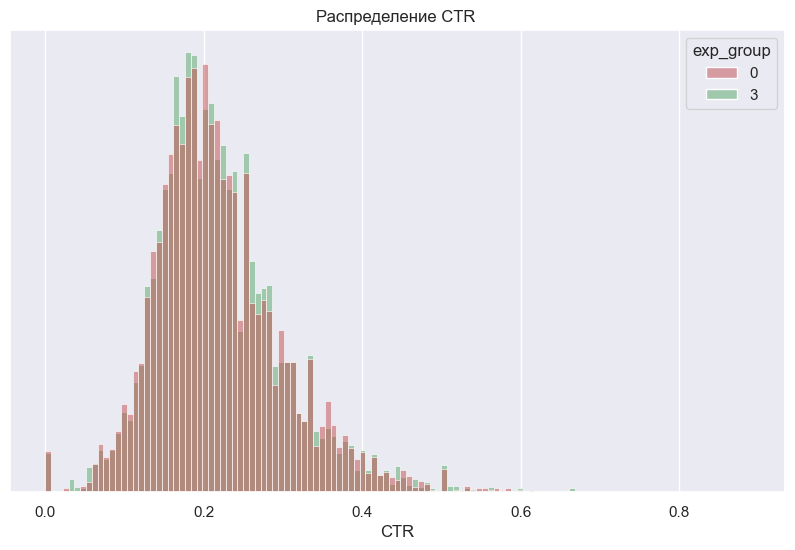

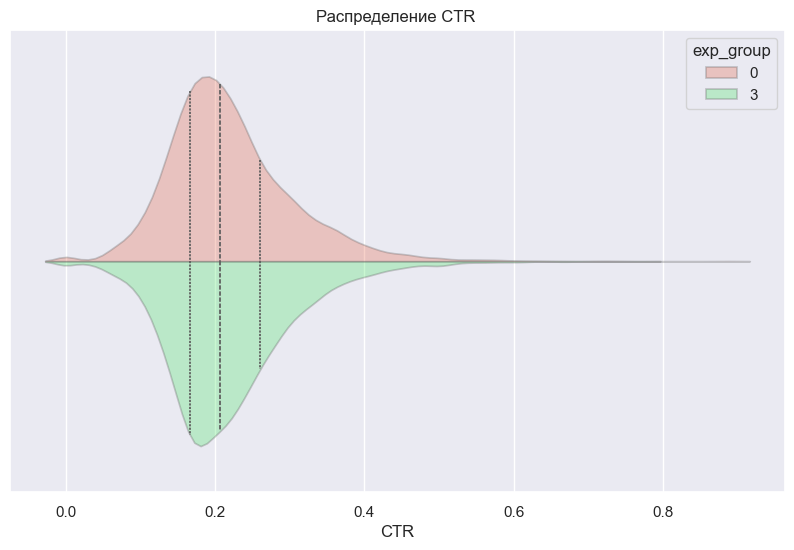

In [7]:
ctr_plot(aa_exp_1_df)

Визуально распределение CTR одинаковы.

Удостоверимся в этом с помощью тестов.

Проверим группы на нормальность распределения.

- H0: Распределения CTR в группах нормальны
- H1: Распределение CTR в группах отличаются от нормальных

Уровень значимости (здесь и далее для всех тестов): `alpha=0.05`

In [8]:
# Формируем подвыборки для групп
aa_test_exp_1 = aa_exp_1_df.query('exp_group == 3')
aa_control_exp_1 = aa_exp_1_df.query('exp_group == 0')

In [9]:
stats.normaltest(aa_test_exp_1.ctr)

NormaltestResult(statistic=1435.2657044384157, pvalue=0.0)

In [10]:
stats.normaltest(aa_control_exp_1.ctr)

NormaltestResult(statistic=1455.6005350935266, pvalue=0.0)

Для обеих групп p-value меньше заданного уровня значимости и равно 0, следовательно мы отвергаем нулевую гипотезу о нормальности распределений CTR в группах. 

Учитывая количество наблюдений в группах (больше 8000), отсутствие сильной скошенности распределений и отсутствие большого количества выбросов, мы могли бы  применить на этих данных и t-test для оценки равенства средних. 

Но "по классике" мы должны бы применить критерий Манна-Уитни.

- H0: Распределение в тестовой выборке соответствует распределению в контрольной выборке
- H1: Распределения не соответствуют друг другу


In [11]:
stats.mannwhitneyu(aa_test_exp_1.ctr, aa_control_exp_1.ctr)

MannwhitneyuResult(statistic=35142094.5, pvalue=0.8469858542240961)

Тест Манна-Уитни показал, что p-value значительно больше 0.05, следовательно у нас нет оснований отвергнуть нулевую гипотезу о соответствии распределений. Следовательно, система сплитования для групп 0 и 3 работает корректно: показатели CTR до проведения эксперимента не различаются.

### 3.2 A/A-тест для эксперимента № 2

Проделаем все эти шаги для групп 1 и 2

In [12]:
aa_exp_2_df = get_ctr(*params['aa_exp_2'])
aa_exp_2_df.head()

Количество пользователей в каждой из групп
exp_group
1    8491
2    8362
Name: user_id, dtype: int64


,exp_group,user_id,likes,views,ctr
0,1,109963,10,34,0.294118
1,1,18392,13,56,0.232143
2,2,131473,19,98,0.193878
3,2,23985,12,44,0.272727
4,2,24523,2,10,0.200000


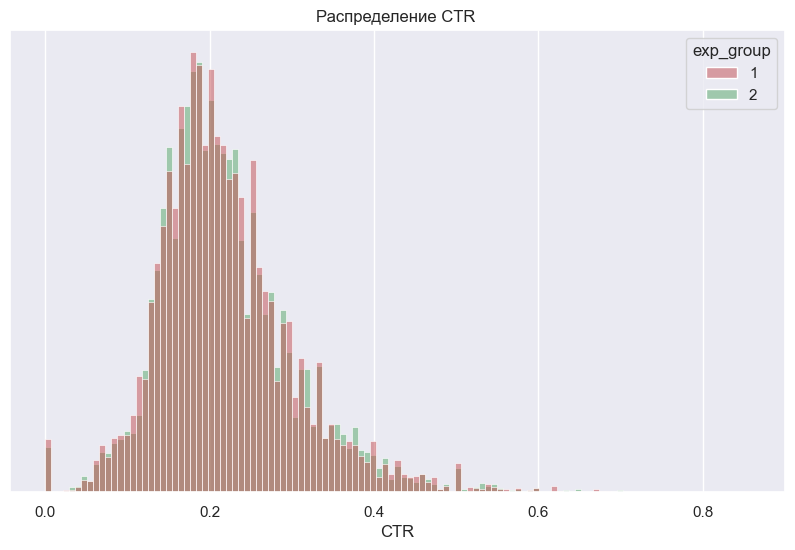

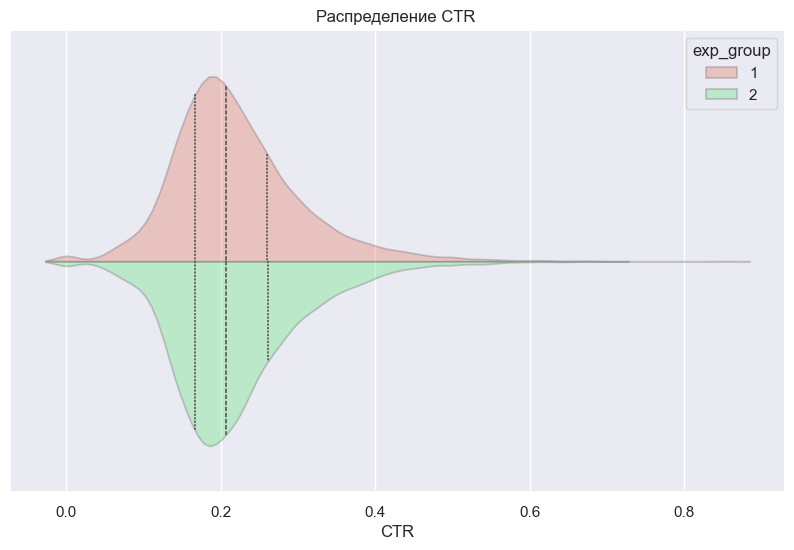

In [13]:
ctr_plot(aa_exp_2_df)

Поскольку визуально полученные распределения очень схожи с распределениями в группах 0 и 3, тест на нормальность проводить нет необходимости, сразу перейдем к тесту Манна-Уитни.

- H0: Распределение в тестовой выборке соответствует распределению в контрольной выборке
- H1: Распределения не соответствуют друг другу

In [14]:
# Формируем подвыборки для групп
aa_test_exp_2 = aa_exp_2_df.query('exp_group == 2')
aa_control_exp_2 = aa_exp_2_df.query('exp_group == 1')

In [15]:
stats.mannwhitneyu(aa_test_exp_2.ctr, aa_control_exp_2.ctr)

MannwhitneyuResult(statistic=35603793.5, pvalue=0.7444783443961298)

В группах второго эксперимента p-value также существенно больше заданного уровня значимости, следовательно у нас нет оснований отвергнуть нулевую гипотезу о соответствии распределений и можно говорить о корректности работы системы сплитования.

### 3.3 Еще один способ проверки корректности системы сплитования

При проведении А/А-теста необходимо убедиться в том, что ключевая метрика не отличается между группами не только в конкретно А/А-тесте, но и в целом.

В идеале было бы здорово провести бесконечное количество А/A-тестов и посмотреть, в каком количестве случаев нам удалось отклонить нулевую гипотезу. Если система сплитования работает корректно, то статистически значимые различия между двумя группами встречались бы только в результате случайного ложного срабатывания. 

Например, если мы отвергаем нулевую гипотезу при условии, что p_value < 0.05, то только приблизительно в 5% случаев у нас бы получались статистические значимые различия между 2 и 3 группой.

Будем многократно извлекать подвыборки из наших данных, проводить t-test, а в конце посмотрим, в каком проценте случаев удалось отклонить нулевую гипотезу.

Проведем симуляцию 10000 А/А-тестов. На каждой итерации будем формировать подвыборки без повторения в 500 пользователей из 2 и 3 экспериментальной группы. Далее, проведем сравнение этих подвыборок t-testом: построим гистограмму распределения получившихся 10000 p-values и посчитаем, какой процент p-values оказался меньше либо равен 0.05.

Для разнообразия для проведения тестов воспользуемся библиотекой `pingouin`.


In [16]:
aa_sim_df = get_ctr(*params['aa_sim'])
aa_sim_df.head()

Количество пользователей в каждой из групп
exp_group
2    8362
3    8425
Name: user_id, dtype: int64


,exp_group,user_id,likes,views,ctr
0,3,115383,38,248,0.153226
1,3,10326,24,132,0.181818
2,3,123580,25,122,0.204918
3,2,131473,19,98,0.193878
4,2,23985,12,44,0.272727


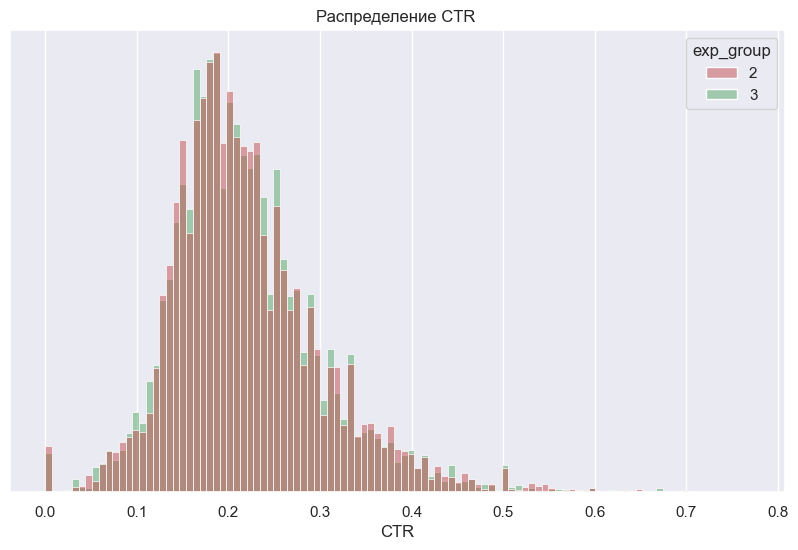

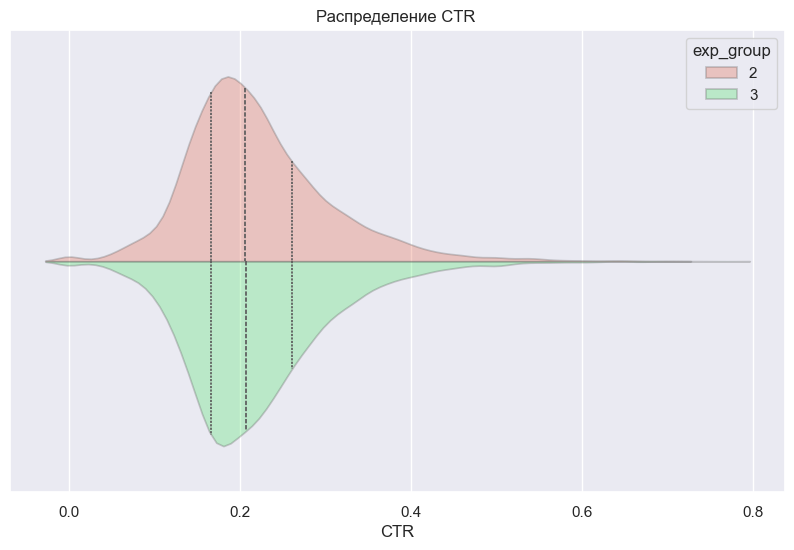

In [17]:
ctr_plot(aa_sim_df)

Опять же, визуально кажется, что распределения эквивалентны по CTR.

Проведем симуляцию 10000 A/A-тестов на выборках из 500 пользователей и сравним подвыборки t-тестом.


In [18]:
def sim_aa_test(df, n_samples=500, n_tests=10000):
    """Функция симулирует проведение заданного числа A/A-тестов
    с применением независимого t-теста Стьюдента,
    рассчитывает процент значений p-value <= 0.05,
    строит гистограмму распределения p-value
    Args:
        df (DataFrame): датафрейм
        n_samles (int, optional): Количество записей в подвыборке. Defaults to 500.
        range (int, optional): Количество проводимых тестов. Defaults to 10000.
    Return: None
    """

    p_val_sum = 0
    p_val_lst = []
    for i in range(n_tests):
        group_2 = df.query('exp_group == 2').sample(n=n_samples, replace=False)
        group_3 = df.query('exp_group == 3').sample(n=n_samples, replace=False)
        p_val = pg.ttest(group_2.ctr, group_3.ctr)['p-val'].values[0]
        p_val_sum += p_val <= 0.05
        p_val_lst.append(p_val)
    
    plt.figure(figsize=(6, 4))
    sns.histplot(p_val_lst, bins=50)
    plt.vlines(x=0.05, ymin=0, ymax=n_tests/50, colors='r')
    plt.title('Распределение полученных значений p-value')
    
    print(f'В {p_val_sum / n_tests * 100:.2f}% случаев p_value <= 0.05')

В 4.74% случаев p_value <= 0.05


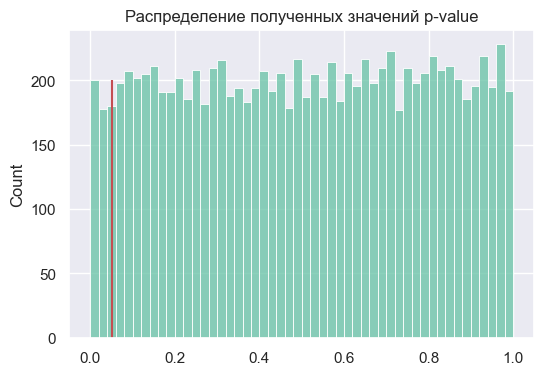

In [19]:
sim_aa_test(aa_sim_df, n_samples=500, n_tests=10000)

Получившиеся значения p-value распределились более-менее равномерно между 0 и 1. В 4.74% случаев мы получили p-value <= 0.05. Это означает, что только в 4.74% случаев мы отклонили нулевую гипотезу и статистически значимые различия между метриками наблюдаются только в результате случайного срабатывания.

Система сплитования работает корректно: количество пользователей в группах приблизительно равное, метрика CTR не отличается между группами.

## 4. A/B-тест

Перед проведением анализа результатов A/B-теста необходимо заранее определиться с конкретным тестом и пользоваться им. Для выбора мы можем использовать исторические данные и испытывать на них различные виды тестов для оценки их точности, интерпретируемости и вычислительной эффективности. 

При непосредственном анализе результатов тестирования нельзя использовать несколько тестов из-за проблемы множественности сравнений, так как использование нескольких тестов на одних и тех же данных существенно повышает вероятность ошибки I-рода. Кроме того, можно получить противоречивые результаты. Но в данном проекте мы рассмотрим несколько тестов для того, чтобы изучить их разнообразие.

### 4.1 A/B-тест для эксперимента № 1

* exp_group = 0 – Контрольная группа
* exp_group = 3 - Рекомендации "постов, которые лайкали похожие на пользователя люди"

In [20]:
ab_exp_1_df = get_ctr(*params['ab_exp_1'])
ab_exp_1_df.head()

Количество пользователей в каждой из групп
exp_group
0     9920
3    10002
Name: user_id, dtype: int64


,exp_group,user_id,likes,views,ctr
0,3,115383,12,44,0.272727
1,3,123580,2,11,0.181818
2,0,4944,8,41,0.195122
3,0,4504,5,15,0.333333
4,0,121508,6,25,0.240000


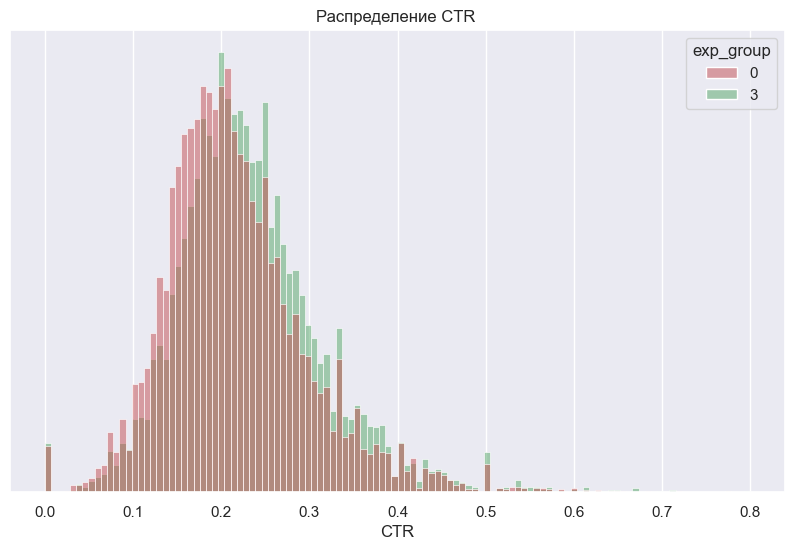

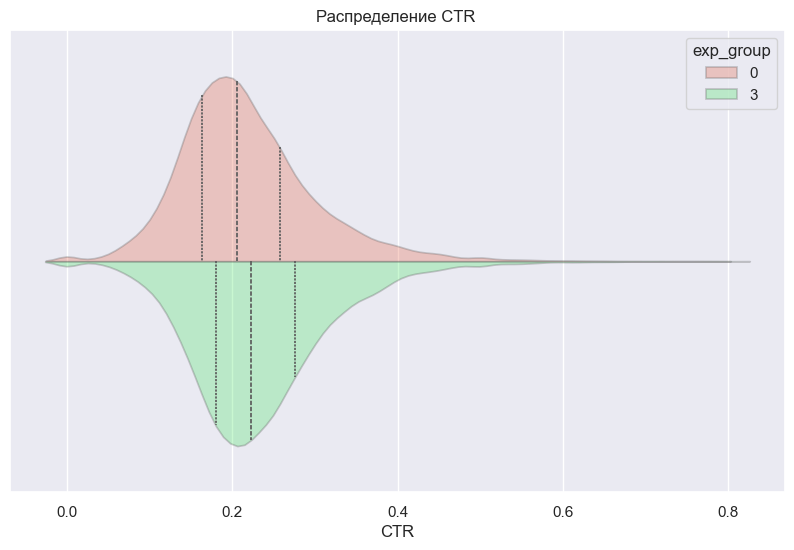

In [21]:
ctr_plot(ab_exp_1_df)

Судя по сдвигу распределения, различия в CTR есть. Проверим это тестами

#### 4.1.1 T-test и критерий  Манна-Уитни

Поскольку выборки достаточно большие и распределения не сильно скошенные и не имеют очень больших выбросов, применим к нашим данным T-test. 

- H0: Средние в группах не различаются
- H1: Средние в группах различаются

Для теста Манна-Уитни гипотезы следующие:

- H0: Распределение в тестовой выборке соответствует распределению в контрольной выборке
- H1: Распределения не соответствуют друг другу

In [22]:
# Формируем подвыборки для групп
ab_test_exp_1 = ab_exp_1_df.query('exp_group == 3')
ab_control_exp_1 = ab_exp_1_df.query('exp_group == 0')

In [23]:
#t-test
stats.ttest_ind(ab_test_exp_1.ctr, ab_control_exp_1.ctr, equal_var=False)

TtestResult(statistic=13.935320516755773, pvalue=6.216047483062228e-44, df=19911.289778579154)

In [24]:
# Тест Манна-Уитни
stats.mannwhitneyu(ab_test_exp_1.ctr, ab_control_exp_1.ctr, alternative='two-sided')

MannwhitneyuResult(statistic=56054380.5, pvalue=8.916679404235955e-57)

Результат T-теста: p-value очень маленькое и близко к 0, следовательно мы должны отвергнуть нулевую гипотезу о равенстве средних в группах;
результат теста Манна-Уитни: p-value также близко к 0, гипотезу о соответствии распределений отвергаем.

То есть в этих тестах мы увидели, что CTR во время проведения эксперимента изменился.

#### 4.1.2 Сглаженный CTR

Проблема t-теста на пользовательском CTR в том, что есть пользователи с небольшим количеством просмотров и мы ничего не знаем о том, как они бы себя вели при большем количестве просмотров. Когда у пользователя есть 20 просмотров, мы можем сделать приемлемую оценку CTR этого пользователя. Если у пользователя 200 просмотров, мы можем практически точно оценить его CTR. Получается, что пользовательский CTR "зашумлен".

Мы можем сгладить оценки CTR воспользовавшись сглаживанием Лапласа. Идея метода применительно к нашим данным состоит в том, что когда просмотров много, сглаженный CTR почти равен CTR пользователя. Когда просмотров мало, сглаженный CTR почти равен общегрупповому CTR. Иначе говоря, если у пользователя много просмотров, мы можем быть уверены, что лайки/просмотры - это хорошая оценка его CTR, а когда у пользователя просмотров мало, мы устанавливаем в качестве оценки общегрупповой CTR.

$$smoothed\_CTR_u = \frac{likes_u + α∗global\_CTR}{views_u + α}$$

где α - гиперпараметр.

У этого метода есть существенный недостаток: теоретической гарантии, что направленность сглаженного CTR совпадает с направленностью общего количества лайков нет. 

Попробуем применить этот метод на наших данных.

In [25]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    """Функция для рассчета сглаженного CTR пользователя

    Args:
        user_likes (int): Количество лайков пользователя
        user_views (int): количество просмотров пользователя
        global_ctr (float): Глобальный CTR для группы
        alpha (float): Гиперпараметр

    Returns:
        float: Сглаженный CTR пользователя
    """
    smothed_ctr = (user_likes + alpha*global_ctr) / (user_views + alpha)
    return smothed_ctr

In [26]:
# Рассчитываем global_ctr для групп
global_ctr_control = ab_control_exp_1.likes.sum() / ab_control_exp_1.views.sum()
global_ctr_test = ab_test_exp_1.likes.sum() / ab_test_exp_1.views.sum()

# Рассчитываем сглаженный CTR
ab_control_exp_1['smothed_ctr'] = ab_exp_1_df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_control, 5), axis=1)

ab_test_exp_1['smothed_ctr'] = ab_exp_1_df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_test, 5), axis=1)

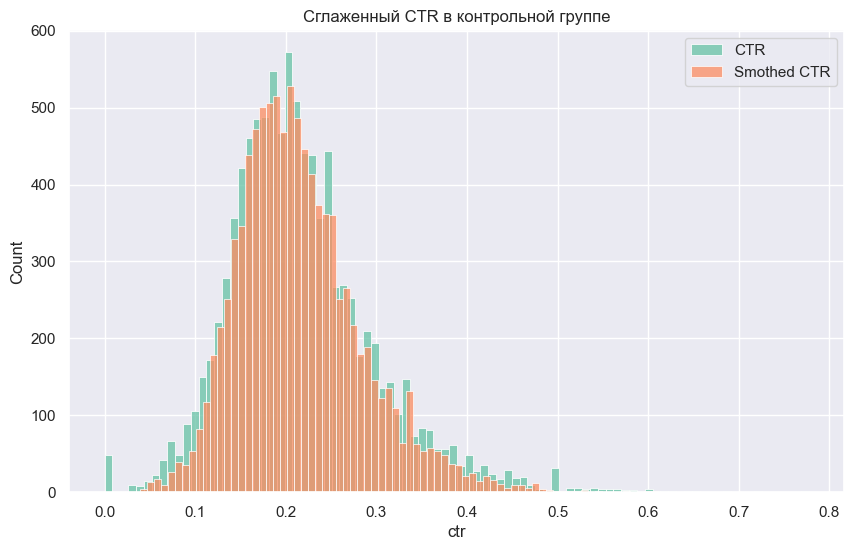

In [27]:
# Визуализируем результат в контрольной группе
sns.histplot(ab_control_exp_1.ctr, label='CTR')
sns.histplot(ab_control_exp_1.smothed_ctr, label='Smothed CTR')
plt.title('Сглаженный CTR в контрольной группе')
plt.legend()
plt.show()

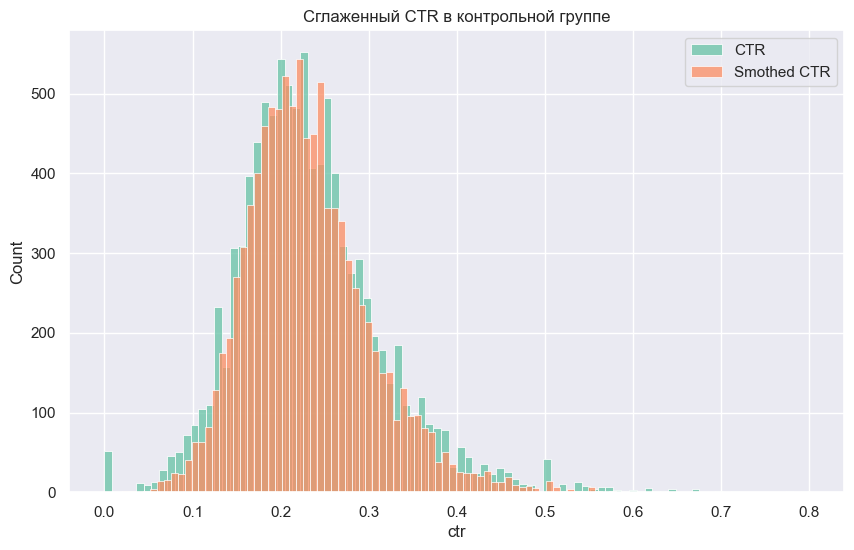

In [28]:
# Визуализируем результат в тестовой группе
sns.histplot(ab_test_exp_1.ctr, label='CTR')
sns.histplot(ab_test_exp_1.smothed_ctr, label='Smothed CTR')
plt.title('Сглаженный CTR в контрольной группе')
plt.legend()
plt.show()

Можно видеть, что CTR действительно сгладился, проведем на сглаженных CTR t-test.

In [29]:
stats.ttest_ind(ab_control_exp_1.smothed_ctr, ab_test_exp_1.smothed_ctr, equal_var=False)

TtestResult(statistic=-16.595522057706155, pvalue=1.9422880220081194e-61, df=19914.595343513993)

T-test показал различия в средних значениях сглаженного CTR в группах, т.к. p-value существенно меньше заданного уровня значимости.

#### 4.1.3 Общегрупповой CTR и бутстреп.

До сих пор мы сравнивали CTR по пользователям. Но, на самом деле, нас интересует общий показатель по всей группе. Для такой оценки мы можем использовать бутстреп.
Идея бутстрепа заключается в том, чтобы оценить статистические характеристики выборки (например, среднее значение, медиану, стандартное отклонение и т. д.) путем многократного повторного выбора элементов из исходной выборки с возвращением. Этот метод позволяет получить оценку распределения выборочной статистики путем генерации большого числа псевдовыборок.

Бутстреп не требователен к распределению, может считать почти любые статистики и строить доверительные интервалы. Но это очень медленно работающий метод.

Для ускорения процесса мы можем считать, сколько раз в псевдовыборку попадает наблюдение. Такая величина будет иметь биномиальное распределение вида:

$$k=Binomial(n,1/n)$$

При таком подходе не все выборки получаются одинаковой длины, но в принципе, это не сильно влияет на результат. 

При большой длине выборки биномиальное распределение - почти тоже самое, что распределение Пуассона:

$$k=Binomial(n,1/n)∼Poisson(1)$$

В нем нет зависимости от n и считается оно быстрее.

Пуассоновский бутстреп для подсчета разницы в CTR:

- Берем выборку из группы A (у нас это $user\_id$ с его $views$ и $likes$)
- Из распределения Пуассона генерируем «сколько раз этот пользователь попал в псевдовыборку». Получается колонка, отражающая «вес» пользователя. Назовем ее $weights_1$
- Считаем «глобальный CTR» по псевдовыборке для A :
$$global\_CTR_A = \frac{sum(likes_A * weights_1)}{sum(views_A * weights_1)}$$
- Берем выборку из группы B (у нас это $user\_id$ с его $views$ и $likes$)
- Из распределения Пуассона генерируем «сколько раз этот пользователь попал в псевдовыборку». Получается колонка, отражающая «вес» пользователя. Назовем ее $weights_2$
- Считаем «глобальный CTR» по псевдовыборке для B :
$$global\_CTR_B = \frac{sum(likes_B * weights_2)}{sum(views_B * weights_2)}$$
- Считаем разницу между $globalCTR_A$ - $globalCTR_B$​​ и записываем эту разность, например, в список
- Повторяем процедуру много раз, например, 2000

Таким образом, мы набираем распределение для разницы в глобальном CTR.

In [30]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    """_summary_

    Args:
        likes1 (numpy.ndarray): Лайки первой группы
        views1 (numpy.ndarray): Просмотры первой группы
        likes2 (numpy.ndarray): Лайки второй группы
        views2 (numpy.ndarray): Просмотры второй группы
        n_bootstrap (int, optional): Количество повторений. Defaults to 2000.

    Returns:
        numpy.ndarray: Массивы глобальных CTR для групп
    """
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    
    poisson_bootstraps2 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = ((poisson_bootstraps1*likes1).sum(axis=1) 
                  / (poisson_bootstraps1*views1).sum(axis=1))
    globalCTR2 = ((poisson_bootstraps2*likes2).sum(axis=1) 
                  / (poisson_bootstraps2*views2).sum(axis=1))
    
    return globalCTR1, globalCTR2

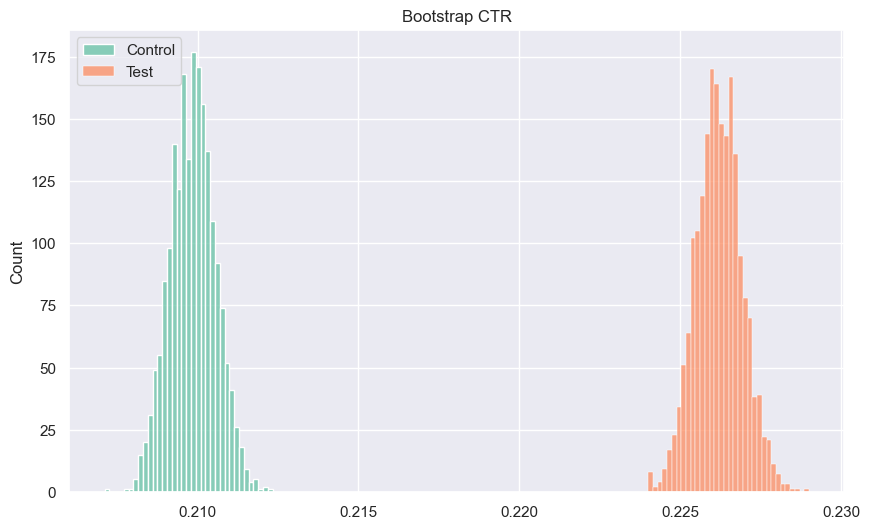

In [31]:
# рассчитываем аргументы
likes1 = ab_control_exp_1.likes.to_numpy()
views1 = ab_control_exp_1.views.to_numpy()
likes2 = ab_test_exp_1.likes.to_numpy()
views2 = ab_test_exp_1.views.to_numpy()

# Набираем распределение
control_ctr, test_ctr = bootstrap(likes1, views1, likes2, views2)

# Визуализируем результат
sns.histplot(control_ctr, label='Control')
sns.histplot(test_ctr, label='Test')
plt.title('Bootstrap CTR')
plt.legend()
plt.show()

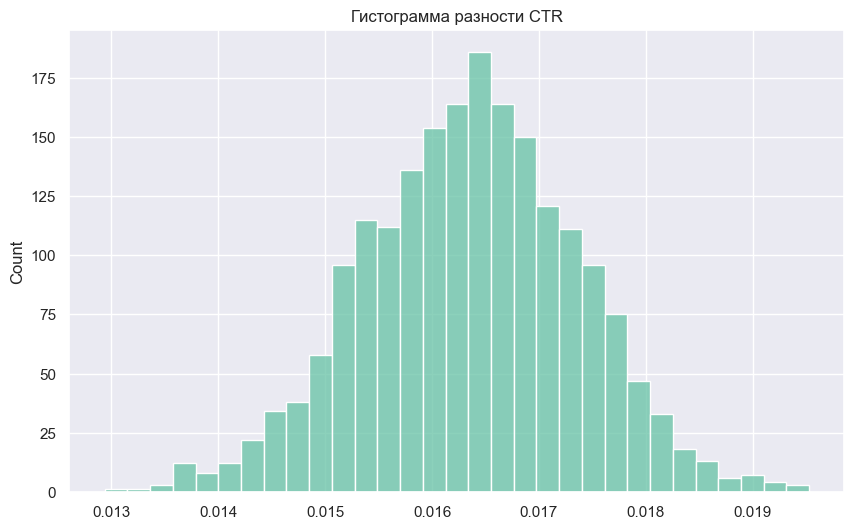

In [32]:
# Визуализируем разницу распределений CTR в группах
sns.histplot(test_ctr-control_ctr)
plt.title('Гистограмма разности CTR')
plt.show()

Как видно, гистограмма распределения CTR в тестовой группе расположена сильно левее контрольной, а гистограмма разности не пересекает 0. Это позволяет утверждать, что CTR в тестовой группе строго больше CTR контрольной группы.

#### 4.1.4 Линеаризация

Исследователи из Яндекса разработали метод анализа тестов над метриками-отношениями вида $x/y$. Идея метода заключаются в том, что вместо того, чтобы тестировать пользовательские CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой новой метрике "прокрасится" и увидит изменения, значит изменения есть и в исходной метрике (то есть в лайках на пользователя и в пользовательских CTR). При этом метод сам по себе довольно прост и гарантирует, что при большом размере выборки можно увеличить чувствительность метрики (или, по-крайней мере, не сделать хуже).

Методика рассчета новой метрики:

- Считаем общий CTR в контрольной группе  $CTRcontrol = sum(likes)/sum(views)$ 
- Считаем в обеих группах поюзерную метрику  $linearized\_likes = likes - CTRcontrol * views$ 


In [33]:
# Расчитываем новую метрику
ab_exp_1_df['ctr_control'] = (ab_exp_1_df.query('exp_group == 0').likes.sum()
                              / ab_exp_1_df.query('exp_group == 0').views.sum()) 
ab_exp_1_df['linearized_likes'] = ab_exp_1_df.likes - ab_exp_1_df.ctr_control*ab_exp_1_df.views

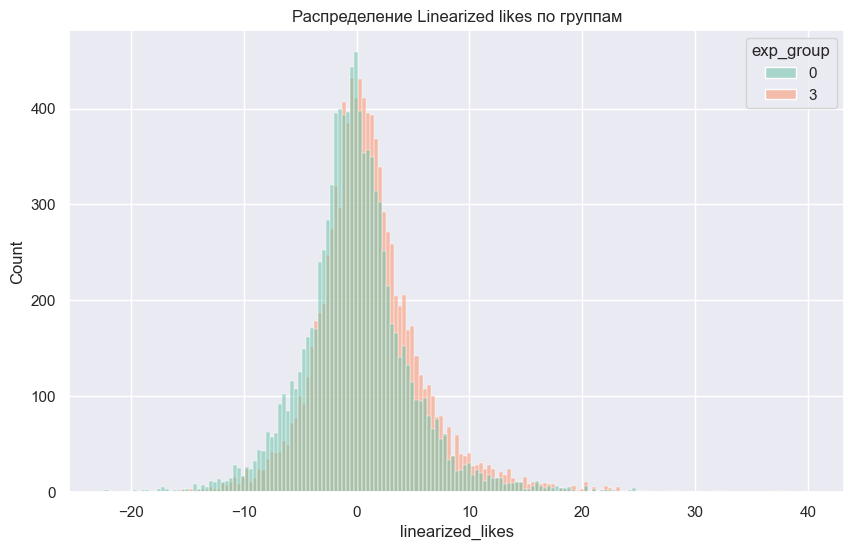

In [34]:
# Визуализируем полученную новую метрику
sns.histplot(data = ab_exp_1_df, x='linearized_likes', hue='exp_group', palette = 'Set2')
plt.title('Распределение Linearized likes по группам')
plt.show()

Поскольку распределения похожи на нормальные, в выборках достаточно много данных и нет очень больших выбросов, можно сказать, что допущения для проведения t-теста соблюдены.

Для t-теста используем левостороннюю гипотезу:

- H0: средние линеаризованных лайков в группах не различаются
- H1: среднее линеаризованных лайков в контрольной группе меньше, чем в тестовой

In [35]:
# T-test на линеаризованных лайках
stats.ttest_ind(ab_exp_1_df.query('exp_group == 0').linearized_likes,
                ab_exp_1_df.query('exp_group == 3').linearized_likes,
                equal_var=False,
                alternative='less')

TtestResult(statistic=-16.186230032932844, pvalue=7.459068872663069e-59, df=19912.67564320342)

Т-тест показал, что p-value практически равен 0, следовательно мы можем отвергнуть нулевую гипотезу о равенстве средних. Линеаризованные лайки в тестовой группе больше, чем в контрольной.

#### 4.1.5 Вывод по эксперименту № 1

В реальной жизни, посмотрев на распределение CTR пользователей, мы должны были бы выбрать тест Манна-Уитни или пуассоновский бутстреп на глобальном CTR, в зависимости от вычислительных ресурсов и других факторов. В любом случае, все проведенные тесты показали различия в группах и статистически значимое увеличение CTR в тестовой группе.

Новый алгоритм рекомендации "постов, которые лайкали похожие на пользователя люди" можно реализовывать для всех пользователей.

### 4.2 A/B-тест для эксперимента № 2

* exp_group = 1 - Контрольная группа
* exp_group = 2 - Рекомендации "похожих на лайкнутые постов"

In [36]:
# Выгружаем данные
ab_exp_2_df = get_ctr(*params['ab_exp_2'])
ab_exp_2_df.head()

Количество пользователей в каждой из групп
exp_group
1    10020
2     9877
Name: user_id, dtype: int64


,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750


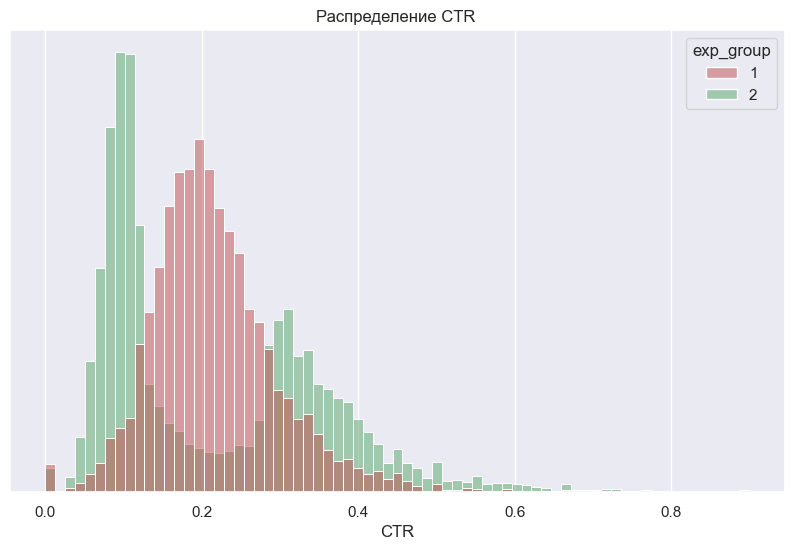

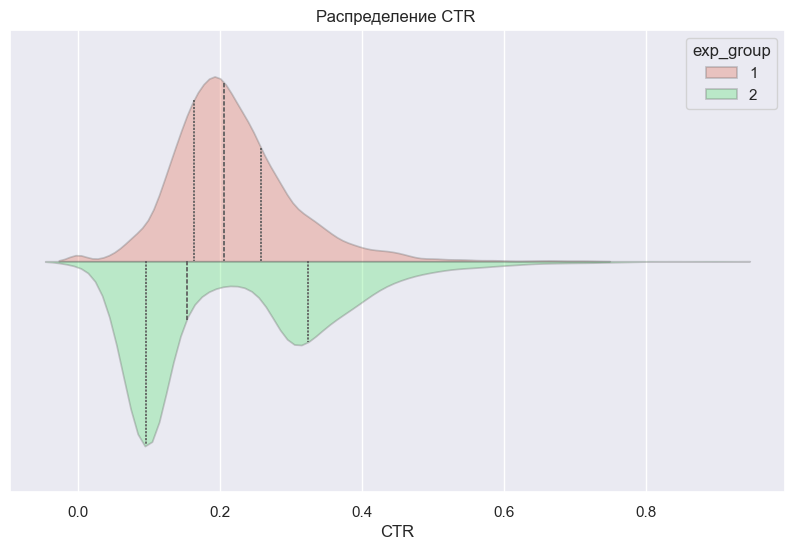

In [37]:
# Визуализируем распределения
ctr_plot(ab_exp_2_df)

Совершенно очевидно, что в тестовой группе произошли серьезные изменения: медиана CTR сместилась влево, а распределение стало двугорбым. В таком случае использовать t-test или тест Манна-Уитни будет явно некорректно.
Проведем анализ общегруппового CTR с использованием пуассоновского бутстрапа.

#### 4.2.1 Общегрупповой CTR и бутстреп.

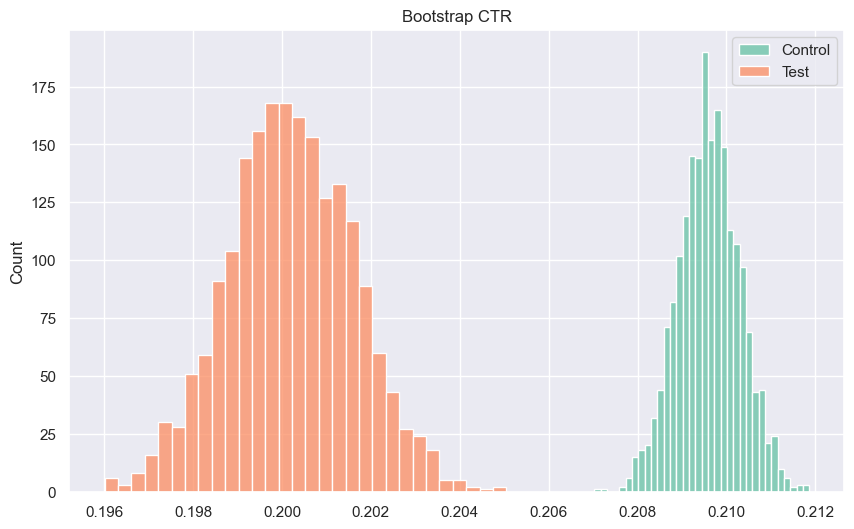

In [38]:
# Формируем подвыборки для групп
ab_test_exp_2 = ab_exp_2_df.query('exp_group == 2')
ab_control_exp_2 = ab_exp_2_df.query('exp_group == 1')

# рассчитываем аргументы
likes1 = ab_control_exp_2.likes.to_numpy()
views1 = ab_control_exp_2.views.to_numpy()
likes2 = ab_test_exp_2.likes.to_numpy()
views2 = ab_test_exp_2.views.to_numpy()

# Набираем распределение
control_ctr, test_ctr = bootstrap(likes1, views1, likes2, views2)

# Визуализируем результат
sns.histplot(control_ctr, label='Control')
sns.histplot(test_ctr, label='Test')
plt.title('Bootstrap CTR')
plt.legend()
plt.show()

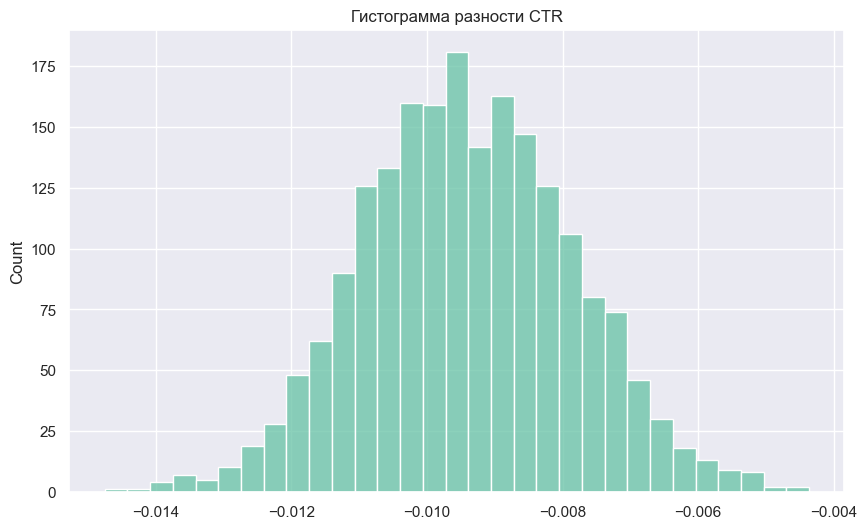

In [39]:
# Визуализируем разницу распределений CTR в группах
sns.histplot(test_ctr-control_ctr)
plt.title('Гистограмма разности CTR')
plt.show()

Гистограмма распределений CTR в контрольной группе расположена сильно левее тестовой и не пересекается с ней, а гистограмма разности находится в отрицательной плоскости и не пересекает 0. Это говорит о том, что показатель общегруппового CTR в результате проведения эксперимента сильно снизился.

#### 4.2.2 Вывод по эксперименту № 2

Снижение общегруппового CTR показывает, что "раскатывать" эксперимент на всех пользователей нельзя.

Но появление бимодального распределения CTR говорит нам о том, что появилось две подгруппы пользователей. Для одной изменения в алгоритме сказались резко отрицательно, а в другой подгруппе CTR вырос. И теперь необходимо будет понять, по какому признаку пользователи разделились на подгруппы? Что их отличает? Нужно выявить пользователей, для которых CTR увеличился и использовать эту точку роста для улучшения алгоритма.

## 5. Общие выводы

В работе были проанализированы результаты двух экспериментов по внедрению новых алгоритмов рекомендаций постов.

Рекомендации "постов, которые лайкали похожие на пользователя люди" показали рост выбранной метрики - CTR пользователей и общегруппового CTR. Этот алгоритм рекомендуется внедрить для всех пользователей.

Рекомендации "похожих на лайкнутые постов" показали снижение общегруппового CTR и внедрение алгоритма для всех пользователей не целесообразно. Однако в тестовой группе выявилось разделение  пользователей на довольно четкие подгруппы, в которых отмечено как снижение, так и увеличение показателя. Пользователи, для которых CTR увеличился требуют дальнейшего изучения, так как здесь есть точка роста для улучшения алгоритма. 